Rafał Nowak
# Numerical Optimization
## Problem set 2 (15 points)

**Submission deadline**: Wednesday, 1.12.2021

* All submissions should contain single file.<br/>This can be single Jupyter notebook file (with extension `ipynb`) or ZIP archive in case the are some additional files needed.
* It is recommended to write the reports using LaTeX. 
* One can report the answers, comments and results in PDF or notebook file.
* All the source code should be written in Python or Julia.

**Needed imports and functions from Problem set 1**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import scipy.sparse as sp

In [2]:
def solve(A, b):
    h = 0
    k = 0
    A = np.append(A, b.reshape(-1, 1), axis=1)
    while h < A.shape[0] and k < A.shape[1]-1:
        index_max = np.argmax(np.abs(A[h:, k])) + h
        if A[index_max, k] == 0:
            k += 1
            continue
        A[[h, index_max]] = A[[index_max, h]]
        for i in range(h+1, A.shape[0]):
            f = A[i, k] / A[h, k]
            A[i, k] = 0
            A[i, k+1:] -= A[h, k+1:] * f
        h += 1
        k += 1
    if all(A[-1, :-1] == 0):
        raise Exception("Matrix A is not full rank")
    for i in range(A.shape[0]-1, -1, -1):
        f = 1/A[i, i]
        A[i, i:] *= f
        A[:i, -1] -= A[i, -1] * A[:i, i]
        A[:i, i] = 0
    return A[:, -1]

In [3]:
def revised_simplex_method(I, c, A, b):
    J = I
    B = A[:, J]
    J_N = np.setdiff1d(np.arange(A.shape[1]), J)
    N = A[:, J_N]
    c_B = c[J]
    c_N = c[J_N]
    B_inv = np.linalg.inv(B)
    x_B = B_inv @ b
    while True:
        B_inv_N = B_inv @ N
#         r_value = c_N - B_inv_N.T @ c_B
        r_value = c_N - N.T @ (B_inv.T @ c_B)
        if all(r_value >= 0):
            x = np.zeros(A.shape[1])
            x[J] = x_B
            return np.sum(c_B * x_B), x
        min_r_i = np.argmin(r_value)
        i = J_N[min_r_i]
        B_inv_A_i = B_inv @ A[:, i]
        if all(B_inv_A_i <= 0):
            raise Exception("Goal function is unbounded from below!")
        ratio = x_B / B_inv_A_i
        min_ratio_j = np.where(ratio > 0, ratio, np.inf).argmin()
        if np.isnan(ratio[min_ratio_j]) or np.abs(ratio[min_ratio_j]) == np.inf:
            raise Exception("Degeneracy!")
        j = J[min_ratio_j]
        J = np.where(J != j, J, i)
        J_N = np.where(J_N != i, J_N, j)
        B = A[:, J]
        J_N = np.setdiff1d(np.arange(A.shape[1]), J)
        N = A[:, J_N]
        c_B = c[J]
        c_N = c[J_N]
        v = np.zeros(x_B.shape[0])
        v[min_ratio_j] = 1.0
        u = A[:, i] - A[:, j]
        B_inv = B_inv - (B_inv_A_i - v).reshape(-1,1) @ B_inv[min_ratio_j].reshape(1, -1) / B_inv_A_i[min_ratio_j]
        B_inv = B_inv - np.outer(B_inv_A_i - v, B_inv[min_ratio_j]) / B_inv_A_i[min_ratio_j]
        x_B = B_inv @ b

**Problem 2.1 (5 pts)**

Assume have a~set of $N$ noisy measurements $(x_i, \tilde y_i)\in\mathbb R^2$ onto which we would like to to fit a line $y=ax+b$. This task can be expressed by the following optimization problem in $L_2$ norm:
$$ \min_{a,b} \sum_{i=1}^N \left(a x_i + b - \tilde y_i\right)^2 = \min_{a,b} \left\| J \begin{pmatrix}a\\b\end{pmatrix} - \tilde y \right\|_2^2,$$
where $\|\cdot\|_2$ means the $L_2$ norm.

One can check that the optimal solution can be obtained by solving the linear system
$$ J^T J \begin{pmatrix}a\\b\end{pmatrix} = J^T \tilde y. $$

* (1 pt) Generate the problem data. Take $N=30, 50, 100$ points in the interval $[0,5]$ and generate the true outputs $y_i = a x_i + b$ for some $a,b\in\mathbb R$; for example take $a=3, b=4$. Add Gaussian noise $~N(0,1)$ to get the noisy measurements $\tilde y_i$ and plot the results.
* (2 pt) Compute the matrix $J$ and solve the problem using your implementation of Gaussian elimination (see problem 1.1). Plot the obtained line in the same graph as the measurements. 
* (1 pt) Next use any implementation (like `np.linalg.solve`) instead of your Gaussian elimination. Compare the resulting const function values.
* (1 pt) Finally, add some outliers to the data and plot the results (single graph with measurements and solution line).

In [26]:
left, right = 0, 5
x30 = np.linspace(left, right, num=30)
x50 = np.linspace(left, right, num=50)
x100 = np.linspace(left, right, num=100)
a, b = 3, 4
y30 = a*x30 + b + np.random.standard_normal(30)
y50 = a*x50 + b + np.random.standard_normal(50)
y100 = a*x100 + b + np.random.standard_normal(100)
x_outliers = np.linspace(left, right, num=10)
y_outliers = np.random.uniform(low=-10.0, high=30.0, size=10)

In [60]:
def calc_first_task(x, y, x_outliers, y_outliers):
    J = np.zeros((x.shape[0], 2))
    J[:, 0] = x
    J[:, 1] = 1
    a, b = solve(J.T @ J, J.T @ y)
    a_np, b_np = np.linalg.solve(J.T @ J, J.T @ y)
    print(f"Consts of my solver: a = {a}, b = {b}\nConsts of numpy solver: a = {a_np}, b = {b_np}")
    fig, axs = plt.subplots(2, figsize=(9, 6))
    axs[0].scatter(x, y)
    axs[0].plot(x, a*x+b)
    axs[0].set_ylabel('')
    x_new = np.append(x, x_outliers)
    y_new = np.append(y, y_outliers)
    J = np.zeros((x_new.shape[0], 2))
    J[:, 0] = x_new
    J[:, 1] = 1
    a, b = solve(J.T @ J, J.T @ y_new)
    a_np, b_np = np.linalg.solve(J.T @ J, J.T @ y_new)
    axs[1].scatter(x, y)
    axs[1].scatter(x_outliers, y_outliers, c="red")
    axs[1].plot(x, a*x+b)
    print(f"Consts of my solver with outliers: a = {a}, b = {b}\nConsts of numpy solver with outliers: a = {a_np}, b = {b_np}")
    plt.show()

Consts of my solver: a = 3.037261336162469, b = 4.250997386150218
Consts of numpy solver: a = 3.037261336162468, b = 4.250997386150221
Consts of my solver with outliers: a = 2.544589277211005, b = 3.8090060697532597
Consts of numpy solver with outliers: a = 2.5445892772110055, b = 3.809006069753259


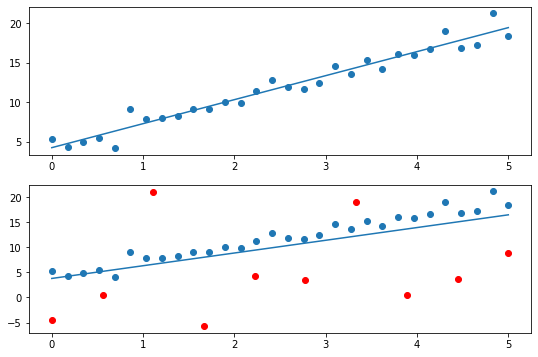

In [61]:
calc_first_task(x30, y30, x_outliers, y_outliers)

Consts of my solver: a = 3.0636364627964494, b = 3.800446867262381
Consts of numpy solver: a = 3.063636462796448, b = 3.8004468672623837
Consts of my solver with outliers: a = 2.7190621349101596, b = 3.610203828178174
Consts of numpy solver with outliers: a = 2.719062134910159, b = 3.610203828178175


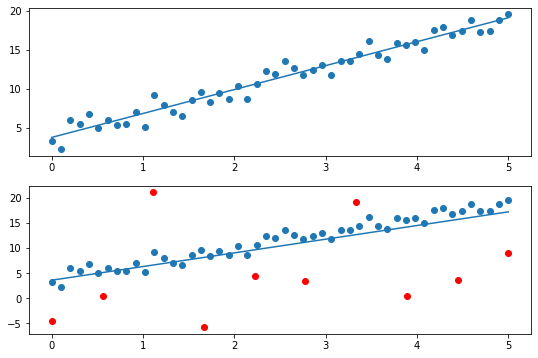

In [62]:
calc_first_task(x50, y50, x_outliers, y_outliers)

Consts of my solver: a = 3.011731453539871, b = 4.016377345243985
Consts of numpy solver: a = 3.01173145353987, b = 4.016377345243989
Consts of my solver with outliers: a = 2.823456398095978, b = 3.9055885195228313
Consts of numpy solver with outliers: a = 2.8234563980959795, b = 3.905588519522828


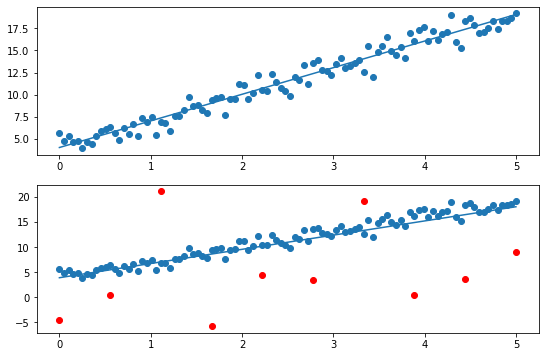

In [63]:
calc_first_task(x100, y100, x_outliers, y_outliers)

Conclusions:
* Consts obtained by my solver are almost the same as ones from np.linalg.solve.
* Lines obtained from minimalization of least square error fits the data with gaussian noise well.
* Outliers shift the obtained lines. Changes are notable the most in case of 30 basic samples. The bigger number of samples with gaussian noise, the smaller the influence of outliers (we can observe that by inspecting coefficient changes).

---

**Problem 2.3 (3 pts)**

In this problem you are going to fit a line to the set of measurements, but this time with $L_1$ norm, i.e.
$$ \min_{a,b} \sum_{i=1}^{N} |a x_i + b - y_i|. $$
which is not diffentiable. Use some slack variables $s_1, s_2, \ldots, s_N$ and reformulate the problem
into the form
$$
\begin{alignat}{2}
                   & \min_{a,b,s} \sum_i s_i,\\
\text{s.t.} \qquad & -s_i \leq ax_i+b-y_i \leq s_i, \qquad & i=1,2,\ldots, N,\\
                   & s_i \geq 0,                           & i=1,2,\ldots, N.
\end{alignat}
$$

* Solve the problem using the measurements generated in the previous exercise (both with and without outliers)
* You can use any LP solver (recommended Gurobi).

Remark. You can get **extra 2 points** if you use your implementation of Simplex method and obtain similar results. Test your method not only with $a=3, b=4$.

In [28]:
def get_gurobi_solution(x, y, x_outliers=None, y_outliers=None):
    if x_outliers is not None or y_outliers is not None:
        x = np.append(x, x_outliers)
        y = np.append(y, y_outliers)

    env = gp.Env(empty=True)
    env.setParam('OutputFlag', 0)
    env.start()
    
    m = gp.Model("mip1", env=env)

    a = m.addVar(vtype=GRB.CONTINUOUS, name="a", lb=-1e21, ub=1e31)
    b = m.addVar(vtype=GRB.CONTINUOUS, name="b", lb=-1e21, ub=1e31)
    
    ss = []
    for i in range(x.shape[0]):
        ss.append(m.addVar(vtype=GRB.CONTINUOUS, name=f"s{i}"))

    obj = ss[0]
    for i in range(1, x.shape[0]):
        obj += ss[i]
        
    m.setObjective(obj, GRB.MINIMIZE)

    for i in range(x.shape[0]):
        m.addConstr(x[i] * a + b - ss[i] <= y[i], f"c{i}0")
        m.addConstr((-x[i]) * a - b - ss[i] <= -y[i], f"c{i}1")

    m.optimize()

    for v in m.getVars():
        if v.varName == "a":
            a = v.x
        if v.varName == "b":
            b = v.x

    return a, b

In [30]:
def calc_second_task(x, y, x_outliers, y_outliers):
    J = np.zeros((x.shape[0], 2))
    J[:, 0] = x
    J[:, 1] = 1
    a_lse, b_lse = solve(J.T @ J, J.T @ y)
    a, b = get_gurobi_solution(x, y, x_outliers=None, y_outliers=None)
    print(f"Consts of L1 norm solution: a = {a}, b = {b}\nConsts of L2 norm solution: a = {a_lse}, b = {b_lse}")
    fig, axs = plt.subplots(2, figsize=(9, 6))
    axs[0].scatter(x, y)
    axs[0].plot(x, a*x+b, c="green", label="L1")
    axs[0].plot(x, a_lse*x+b_lse, c="red", label="L2")
    axs[0].set_ylabel('')
    axs[0].legend()
    x_new = np.append(x, x_outliers)
    y_new = np.append(y, y_outliers)
    J = np.zeros((x_new.shape[0], 2))
    J[:, 0] = x_new
    J[:, 1] = 1
    a_lse, b_lse = solve(J.T @ J, J.T @ y_new)
    a, b = get_gurobi_solution(x, y, x_outliers=None, y_outliers=None)
    axs[1].scatter(x, y)
    axs[1].scatter(x_outliers, y_outliers, c="red")
    axs[1].plot(x, a*x+b, c="green", label="L1")
    axs[1].plot(x, a_lse*x+b_lse, c="red", label="L2")
    axs[1].legend()
    print(f"Consts of L1 norm solution with outliers: a = {a}, b = {b}\nConsts of L2 norm solution with outliers: a = {a_lse}, b = {b_lse}")
    plt.show()

Consts of L1 norm solution: a = 2.872868644792128, b = 4.32837611725683
Consts of L2 norm solution: a = 2.891197414237553, b = 4.104178495334444
Consts of L1 norm solution with outliers: a = 2.872868644792128, b = 4.32837611725683
Consts of L2 norm solution with outliers: a = 2.3119675923804137, b = 4.523906374931013


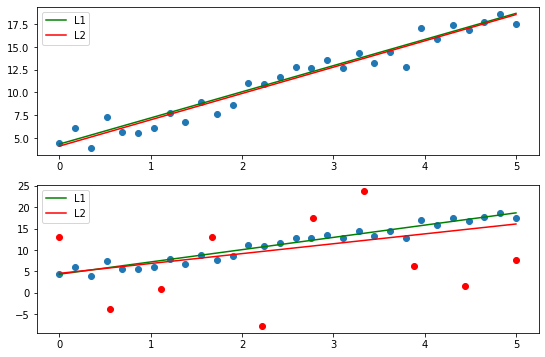

In [32]:
calc_second_task(x30, y30, x_outliers, y_outliers)

Consts of L1 norm solution: a = 2.995616630453662, b = 4.148847980418761
Consts of L2 norm solution: a = 2.9132697270579277, b = 4.365799254895634
Consts of L1 norm solution with outliers: a = 2.995616630453662, b = 4.148847980418761
Consts of L2 norm solution with outliers: a = 2.509856659735378, b = 4.6359672162358


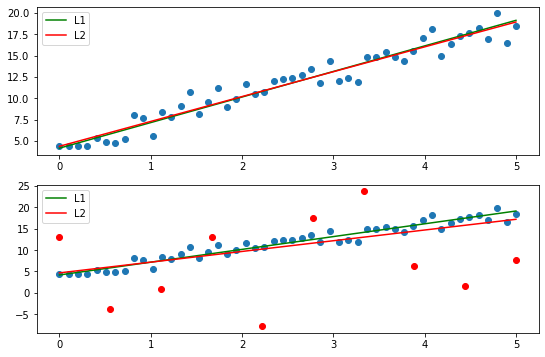

In [33]:
calc_second_task(x50, y50, x_outliers, y_outliers)

Consts of L1 norm solution: a = 2.8078438609688896, b = 4.56808774545676
Consts of L2 norm solution: a = 2.8696293842119824, b = 4.265046590139322
Consts of L1 norm solution with outliers: a = 2.8078438609688896, b = 4.56808774545676
Consts of L2 norm solution with outliers: a = 2.6473724801180913, b = 4.437022057653495


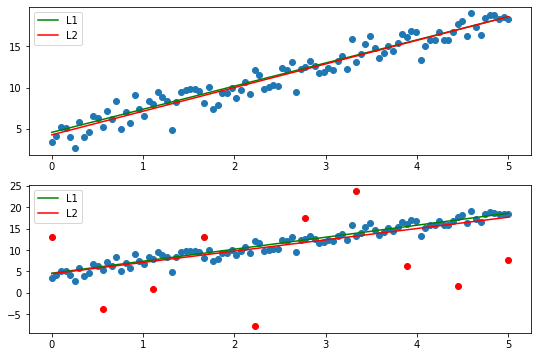

In [34]:
calc_second_task(x100, y100, x_outliers, y_outliers)

Conclusions:
* When there are no outliers, both regressions yields similar results.
* L1 norm regression is more robust to outliers than L2 norm. The effect is biggest when number of points is the smallest (the biggest contribution of outliers in overall number of points).

In [36]:
# def get_my_solution(x, y, x_outliers=None, y_outliers=None):
#     if x_outliers is not None or y_outliers is not None:
#         x = np.append(x, x_outliers)
#         y = np.append(y, y_outliers)
# #         vars = (s_i[], l_i[], r_i[], a1,2, b1,2)
#     n = x.shape[0]
#     c = np.zeros(3*n+4, dtype=np.float64)
#     c[:n] = 1.0
#     b = np.zeros(2*n, dtype=np.float64)
#     b[:n] = y
#     b[n:] = y
#     A = np.zeros((2*n, 3*n+4), dtype=np.float64)

# #     -s_i = a x_i + b - y_i - l_i
# #      y_i = x_i * <a> + 1*<b> - <l_i> + <s_i>
#     for i in range(n):
#         A[i, 3*n] = x[i]
#         A[i, 3*n+1] = -x[i]
#         A[i, 3*n+2] = 1
#         A[i, 3*n+3] = -1
#         A[i, i] = 1
#         A[i, n+i] = -1

# #      a x_i + b - y_i + r_i = s_i
# #      y_i = x_i * <a> + 1*<b> + <r_i> - <s_i>
#     for i in range(n):
#         A[n+i, 3*n] = x[i]
#         A[n+i, 3*n+1] = -x[i]
#         A[n+i, 3*n+2] = 1
#         A[n+i, 3*n+3] = -1
#         A[n+i, i] = -1
#         A[n+i, 2*n+i] = 1
    
#     def find_feasible_solution(c, A, b):
#         A = np.copy(A)
#         b = np.copy(b)
#         c = np.copy(c)
#         n = b.shape[0] // 2
#         diagonal = np.where(b<0, -1.0, 1.0)
#         A_new = np.concatenate((A, np.diag(diagonal)), axis=1)
#         c_new = np.zeros(3*n+4+2*n, dtype=np.float64)
#         c_new[-2*n:] = 1.0
#         I = np.array(np.arange(3*n+4, 5*n+4))
#         f, xs = revised_simplex_method(I, c_new, A_new, b)
#         return f, xs
        
#     f, xs = find_feasible_solution(c, A, b)
#     I = np.argsort(np.abs(xs))[::-1]
    
# #     I = np.array(np.arange(n, 3*n))
# #     I = np.concatenate((np.array(np.arange(n)),np.array(np.arange(2*n, 3*n))))
# #     I = np.array(np.arange(0, 2*n))

#     print(A)
#     f, xs = revised_simplex_method(I, c, A, b)
#     print(xs)
#     return f, xs[3*n], xs[3*n+1], xs[3*n+2], xs[3*n+3]

In [35]:
# get_my_solution(x30, y30)

**Problem 2.4** (3 pts)

In this problem we consider univariate function $f:\mathbb R\to\mathbb R$.
Let us remind the idea of bracketing method
> _Bracketing_ is the process of identifying an interval in which a local minimum lies and then successively shrinking the interval.

Implement the method `(a,b) = find_initial_bracket(f)` which for given function $f$ gives the bracketing interval $(a,b)$ such that there exist local minimum $c\in(a,b)$ satisfying $f(a)>f(c)<f(b)$.

```julia
function find_initial_bracket(f, x=0; s=1e-2, k=2.0)

end
```

```julia
# Example test
f(x) = 3*x^2 + exp(.3*x-9) + 20*x - 20
a, b = find_initial_bracket(f)
@show a, b
```
`(a, b) = (-5.109999999999999, -1.27)`

```julia
using Plotly
plot( f, a , b )
```
<a href="https://ibb.co/kXNfFMh"><img src="https://i.ibb.co/ZxqPCNh/f-bracket.png" alt="f-bracket" border="0"></a>

**Problem 2.5** (4 pts)

In this problem we consider [unimodal function](https://www.wikiwand.com/en/Unimodality#/Unimodal_function)
and will play with _golden section search_ method.

First you should implement the _Fibonacci search_ algorithm provided that you have the (global) array of Fibonacci numbers. Next you should implement the _golden section search_ which uses only _golden ratio_ $\varphi = (1+\sqrt 5)/2$.

* Implement the [Fibonacci search algorithm](https://www.wikiwand.com/en/Golden-section_search#/Fibonacci_search)<br/>`(a, b) = fibonacci_search(f, a, b, n; ε=1e-4)`<br/>to be run on univariate function $f$, with bracketing interval $[a, b]$, for $n > 1$ function evaluations. It should return the new interval $(a, b)$. The optional parameter $\varepsilon$ should control the lowest-level interval length.
* Implement [Golden section search](https://www.wikiwand.com/en/Golden-section_search#)<br/>`(a, b) = gs_search(f, a, b, n)`<br/> to be run on a univariate function $f$ , with bracketing interval $[a, b]$ , for $n > 1$ function evaluations. It returns the new interval $(a, b)$. Guaranteeing convergence to within $\varepsilon$ requires $n = (b-a)/(\varepsilon \ln\varphi)$.

Present the results on various kind of functions.

References:
- [Fibonacci Search in Optimization of Unimodal Functions](https://www.maplesoft.com/applications/view.aspx?SID=4193&view=html)
- [Golden section search](https://www.wikiwand.com/en/Golden-section_search#)

In [2]:
def find_initial_bracket(f, x=0, s=1e-2, k=2.0):
    a = x
    b = x + s
    f_b = f(b)
    f_a = f(a)
    if f_a < f_b:
        a, b = b, a
        f_a, f_b = f_b, f_a
        s = -s
    x = b + s
    f_x = f(x)
    while f_x < f_b:
        b = x
        a = b
        s *=k
        f_b = f_x
        x = b + s
        f_x = f(x)
    return min(x, a), max(x, a)

-5.109999999999999 -2.55


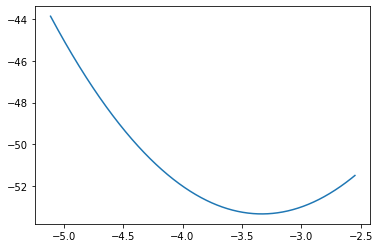

In [3]:
f = lambda x : 3*x**2 + np.exp(0.3*x-9) + 20*x - 20
a, b = find_initial_bracket(f)
print(a,b)
xvals = np.linspace(a,b,1000)
yvals = list(map(f, xvals))
plt.plot(xvals, yvals)

In [4]:
class Fib:
    def __init__(self):
        self.numbers = []
        self.numbers.append(0.0)
        self.numbers.append(1.0)
        self.k_max = 1
    def __getitem__(self, k):
        if k <= self.k_max:
            return self.numbers[k]
        for i in range(self.k_max+1, k+1):
            self.numbers.append(self.numbers[-2]+self.numbers[-1])
        self.k_max = k
        return self.numbers[-1]

In [9]:
# initialize first k fib values
fib = Fib()
_ = fib[10000]

In [36]:
def fibonacci_search(f, a, b, n, ε=1e-4):
    v = (b-a)/ε
    n_fib = 0
    while fib[n_fib] < v:
        n_fib += 1
    cl = a + (fib[n_fib - 2] / fib[n_fib]) * (b - a)
    cr = a + (fib[n_fib - 1] / fib[n_fib]) * (b - a)
    f_cl = f(cl)
    f_cr = f(cr)
    k = 2
    while k <= n:
        if f_cl < f_cr:
            b = cr
            cr, f_cr = cl, f_cl
            n_fib -= 1
            cl = a + (fib[n_fib - 2] / fib[n_fib]) * (b - a)
            f_cl = f(cl)
        else:
            a = cl
            cl, f_cl = cr, f_cr
            n_fib -= 1
            cr = a + (fib[n_fib - 1] / fib[n_fib]) * (b - a)
            f_cr = f(cr)
        k += 1
        bracket = (a, cr) if f_cl < f_cr else (cl, b)
        if bracket[1] - bracket[0] < ε:
            return bracket
    return bracket

In [12]:
def gs_search(f, a, b, n):
    invphi = (np.sqrt(5) - 1) / 2 
    invphi2 = (3 - np.sqrt(5)) / 2
    interval = b - a
    cl = a + invphi2 * interval
    cr = a + invphi * interval
    f_cl = f(cl)
    f_cr = f(cr)
    k = 2
    while k <= n:
        if f_cl < f_cr:
            b = cr
            cr, f_cr = cl, f_cl
            interval *= invphi
            cl = a + invphi2 * interval
            f_cl = f(cl)
        else:
            a = cl
            cl, f_cl = cr, f_cr
            interval *= invphi
            cr = a + invphi * interval
            f_cr = f(cr)
        k += 1
    return (a, cr) if f_cl < f_cr else (cl, b)

In [72]:
def run_experiment_gs_search(f, n):
    a, b = gs_search(f, *find_initial_bracket(f), n)
    print(f"gs_search:\nFinal bracket: ({a}, {b})\nLength of bracket: {b-a}")
    xvals = np.linspace(a, b, 100)
    yvals = list(map(f, xvals))
    plt.plot(xvals, yvals)
    plt.show()

def run_experiment_fibonacci_search(f, n):
    a, b = fibonacci_search(f, *find_initial_bracket(f), n)
    print(f"fibonacci_search:\nFinal bracket: ({a}, {b})\nLength of bracket: {b-a}")
    xvals = np.linspace(a, b, 100)
    yvals = list(map(f, xvals))
    plt.plot(xvals, yvals)
    plt.show()

def run_experiments(f, n):
    print("Plot of function on interval (-10, 10)")
    xvals = np.linspace(-10, 10, 10000)
    yvals = list(map(f, xvals))
    plt.plot(xvals, yvals)
    plt.show()
    run_experiment_gs_search(f, n)
    run_experiment_fibonacci_search(f, n)

Plot of function on interval (-10, 10)


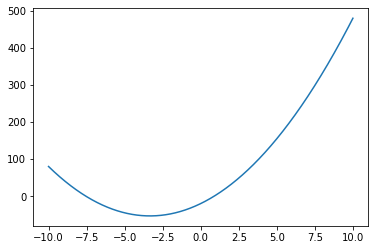

gs_search:
Final bracket: (-3.338626700831225, -3.31781231681642)
Length of bracket: 0.020814384014804954


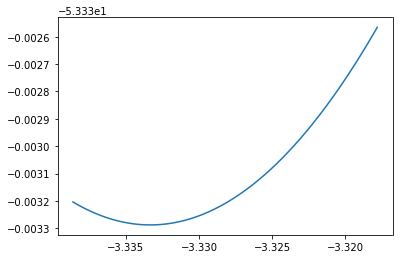

fibonacci_search:
Final bracket: (-3.3386268625466724, -3.3178124018564397)
Length of bracket: 0.02081446069023274


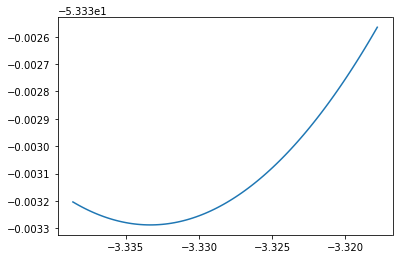

In [73]:
f = lambda x : 3*x**2 + np.exp(0.3*x-9) + 20*x - 20
run_experiments(f, 10)

Plot of function on interval (-10, 10)


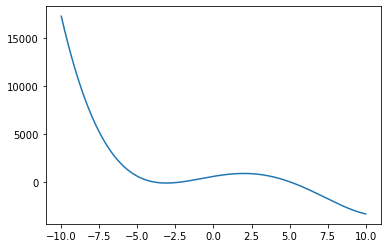

gs_search:
Final bracket: (-3.0998412575938086, -3.079026873579003)
Length of bracket: 0.020814384014805398


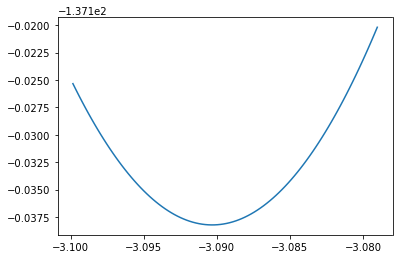

fibonacci_search:
Final bracket: (-3.0998412255295387, -3.079026764839306)
Length of bracket: 0.02081446069023274


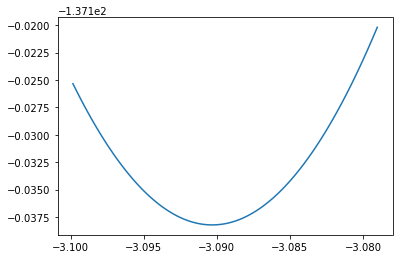

In [74]:
f = lambda x : x**4 - 13*x**3 - 36*x**2 + 268*x + 560
run_experiments(f, 10)

Plot of function on interval (-10, 10)


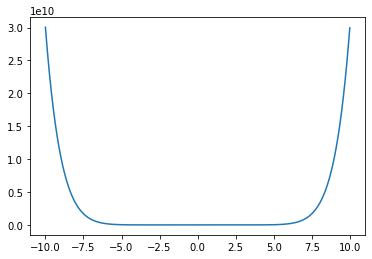

gs_search:
Final bracket: (1.057584539199058, 1.0627881352027595)
Length of bracket: 0.005203596003701572


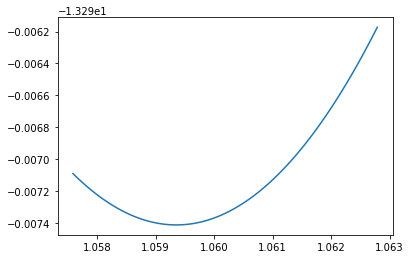

fibonacci_search:
Final bracket: (1.0575846267553584, 1.0627878787878788)
Length of bracket: 0.005203252032520478


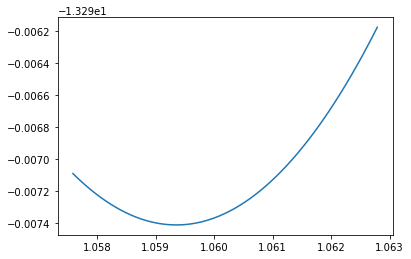

In [75]:
f = lambda x : 3*x**10 - 5*x**7 + 2*x**6 -8*x**2 - 5
run_experiments(f, 10)

Plot of function on interval (-10, 10)


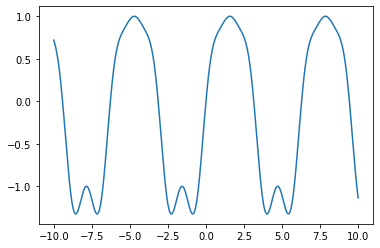

gs_search:
Final bracket: (-0.8712422480060567, -0.8660386520023553)
Length of bracket: 0.0052035960037013496


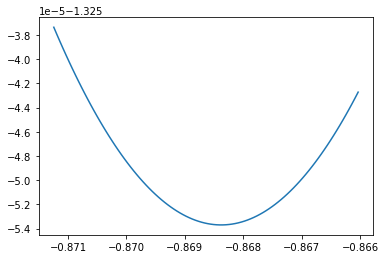

fibonacci_search:
Final bracket: (-0.8712416851441244, -0.866038433111604)
Length of bracket: 0.005203252032520367


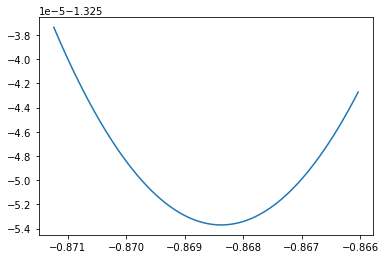

In [76]:
f = lambda x : np.sin(x) + np.cos(x)**2 * np.sin(x) - np.sin(x)**2 * np.cos(x)**2
run_experiments(f, 10)

Plot of function on interval (-10, 10)


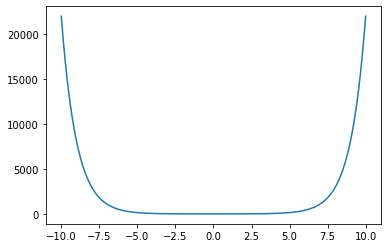

gs_search:
Final bracket: (-3.1056200151419495e-05, 0.00013155617496424742)
Length of bracket: 0.0001626123751156669


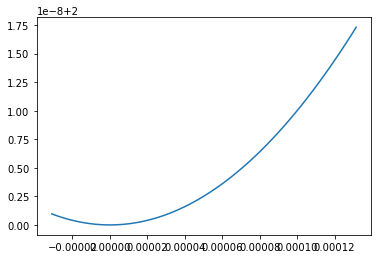

fibonacci_search:
Final bracket: (-4.2918454935621426e-05, 0.0001287553648068679)
Length of bracket: 0.00017167381974248934


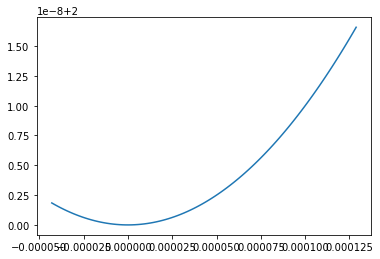

In [77]:
f = lambda x : np.exp(x) + np.exp(-x)
run_experiments(f, 10)

We can see that search algorithms works very well on different types of functions such as polynomials, trigonometric, rationals and hyperbolic. Both algorithms achives very similar brackets, however gs_search gives a bit smaller interval.